In [1]:
import os

model_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')

In [2]:
# pre-trained models
model_names = [
    "unsloth/llama-3-8b-bnb-4bit", #acc .5
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-8b-Instruct", #recall .82, acc .55
    "unsloth/llama-3-8b", #recall .69, acc .54
]

## load model and dataset

In [3]:
from unsloth import FastLanguageModel

# max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
max_seq_length = 128
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True

model_name = "llama-3-8b-Instruct"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = 'unsloth/' + model_name,
    load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    NVIDIA GeForce RTX 3060. Num GPUs = 1. Max memory: 11.634 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.0. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
# load dataset
from datasets import load_from_disk

ds = load_from_disk(os.path.join(model_dir, 'ds_epitope_split_space'))

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3023723
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 159144
    })
})

In [6]:
# format data
catogories = ['No', 'Yes']
rank_to_label = {i:n for i,n in enumerate(catogories)}
label_to_rank = {n:i for i,n in enumerate(catogories)}

# def format_data(example, tokenizer, rank_to_label):
#     word_label = rank_to_label[example['label']]
#     example['token'] = tokenizer.encode(word_label, add_special_tokens=False)[0]
#     return example
# ds = ds.map(format_data, fn_kwargs={'tokenizer': tokenizer, 'rank_to_label': rank_to_label})

prompt = """
Here is an amino acid sequence:
{}

Is this sequence identified as Yes or No ? Answer with "Yes" or "No".

SOLUTION
The correct answer is:
{}
"""

## prepare model

In [7]:
positivelabel = "Yes"
negativelabel = "No"

yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("No", add_special_tokens=False)[0]

def formatting_prompts_func(dataset_):
    # this is to fix an issue with the transformers library where the first time this function is called, it is called with a string for some reason
    if isinstance(dataset_['text'], str):
        return [" "]*100
        
    texts = []
    for i in range(len(dataset_['text'])):
        t = dataset_['text'][i]
        label = positivelabel if dataset_['label'][i] == 1 else negativelabel
        text = prompt.format(t, label)
        texts.append(text)
    return texts
# test one
formatting_prompts_func(ds['test'][:10])[0]

'\nHere is an amino acid sequence:\nN A L L L L F F W\n\nIs this sequence identified as Yes or No ? Answer with "Yes" or "No".\n\nSOLUTION\nThe correct answer is:\nNo\n'

In [8]:
from peft import LoftQConfig


model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head", # can easily be trained because it has only 2 tokens
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = 'loftq',
    # loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1), # And LoftQ
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 567279616


In [9]:
from transformers import DataCollatorForLanguageModeling
from typing import Any, Dict, List, Union

# this custom collator is needed to change the sequence labels from yes_token_id and no_token_id to 1 and 0. It also trains only on the last token of the sequence.
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Find the last non-padding token
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            # Set all labels to ignore_index except for the last token
            batch["labels"][i, :last_token_idx] = self.ignore_index
            # The old labels for the Yes and No tokens need to be mapped to 1 and 0
            batch["labels"][i, last_token_idx] = 1 if batch["labels"][i, last_token_idx] == yes_token_id else 0


        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

In [10]:
import torch
from transformers import TrainingArguments
# 300
args = TrainingArguments(
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 1,
    warmup_ratio = .2,
    # num_train_epochs = 1,
    max_steps=400,
    learning_rate = 5e-7,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 10,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",
    seed = 3407,
    output_dir = os.path.join(model_dir, model_name, "outputs"),
    # report_to = "wandb",
    report_to = "none",
    group_by_length = True,
)

In [11]:
import torch
from trl import SFTTrainer
from transformers import Trainer

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = ds['train'],
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # not needed because group_by_length is True
    args = args,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)
trainer_stats = trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/3023723 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,023,723 | Num Epochs = 1 | Total steps = 400
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 567,279,616/8,000,000,000 (7.09% trained)


Step,Training Loss
10,9.564400
20,9.596800
30,8.809100
40,8.730200
50,8.653600
60,9.461800
70,9.049100
80,8.480400
90,8.342600
100,7.832200


Unsloth: Will smartly offload gradients to save VRAM!


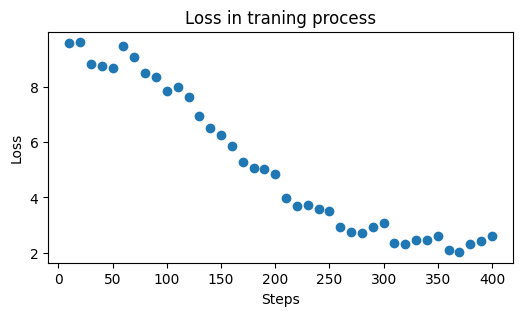

In [12]:
from trainer_plot import TrainerPlot

TrainerPlot.loss(trainer)

In [13]:
import os

saved_name = os.path.join(model_dir, model_name, 'model')
print(saved_name)
model.save_pretrained(saved_name)

/home/yuan/bio/ml_epitope/models/llama-3-8b-Instruct/model


In [14]:
# # evaluate model using 
# import pandas as pd
# from fine_tune import FineTune

# stat = ft.trainer_predict(trainer, ds['test'])

## test

In [15]:
%reload_ext autoreload
%autoreload 2

In [16]:
# from unsloth import FastLanguageModel

# # max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
# max_seq_length = 50
# dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
# load_in_4bit = True

# model0, tokenizer0 = FastLanguageModel.from_pretrained(
#     '/home/yuan/bio/ml_epitope/models/llama-3-8b-bnb-4bit_epitope/llama-3-8b-bnb-4bit_epitope',
#     load_in_4bit = load_in_4bit,
#     max_seq_length = max_seq_length,
#     dtype = dtype,
# )

In [17]:
# evaluate model using 
import pandas as pd
from fine_tune import FineTune

stat = pd.DataFrame()
ft = FineTune(model, tokenizer)
chunk_size = 1000
for i in range(0, 10000, chunk_size):
    sub = ds['test'][i:i+chunk_size]
    sub=[{'text':k, 'label':v} for k,v in zip(sub['text'], sub['label'])]
    print(i, end=',')
    sub_stat = ft.predict(sub, prompt, label_to_rank)
    stat = pd.concat([stat, sub_stat])

0,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.99s/it]


1000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:49<00:00,  1.85s/it]


2000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:49<00:00,  2.08s/it]


3000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:50<00:00,  2.01s/it]


4000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:49<00:00,  2.05s/it]


5000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:49<00:00,  2.07s/it]


6000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:50<00:00,  1.68s/it]


7000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:49<00:00,  2.06s/it]


8000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:49<00:00,  1.92s/it]


9000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:49<00:00,  2.13s/it]


In [18]:
from collections import Counter
Counter(stat['predicts'])

Counter({'Yes': 8123, 'No': 1877})

In [19]:
from trainer_plot import TrainerPlot
TrainerPlot.scores(stat)

Total:  10000
true classifications: Counter({1: 5620, 0: 4380})
predictions:  Counter({1: 8123, 0: 1877})


{'recall': 0.8637010676156583,
 'precision': 0.5975624769173951,
 'F1 score': 0.7063959834097359,
 'accuracy': 0.5965}

confusion matrix:
 [[1111 3269]
 [ 766 4854]]


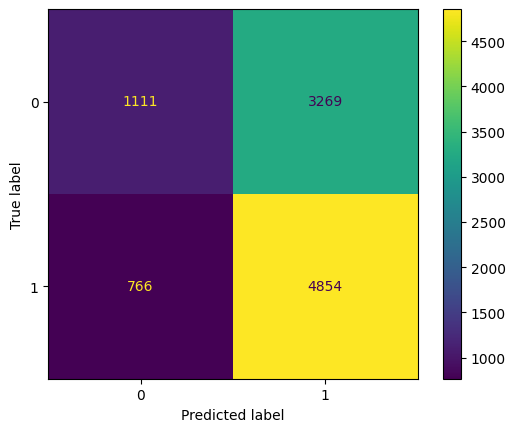

In [20]:
TrainerPlot.cm(stat)